C:\Users\Антон\Documents\GitHub\dano\.venv\Lib\site-packages\statsmodels\base\model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Таблица результатов
| Segment                    |     N |   AUC |    OR |   P-value |
|:---------------------------|------:|------:|------:|----------:|
| Seg: Высокодоходные с ПМ   |   448 | 0.813 | 0.269 |     0.065 |
| Age: Не определен          |   866 | 0.811 | 0.941 |     0.842 |
| Age: Взрослые              | 10087 | 0.777 | 1.230 |     0.007 |
| Seg: Доходные              |  9569 | 0.801 | 1.249 |     0.003 |
| Age: Unknown               |   262 | 0.861 | 1.262 |     0.837 |
| Citizen: RF                | 18359 | 0.800 | 1.283 |     0.000 |
| GLOBAL (All)               | 18791 | 0.805 | 1.300 |     0.000 |
| Age: Молодежь              |  4171 | 0.856 | 1.372 |     0.029 |
| Age: Сеньоры               |  2277 | 0.778 | 1.576 |     0.005 |
| Seg: Высокодоходные без ПМ |   715 | 0.835 | 1.701 |     0.076 |
| Citizen: Other             |   432 | 0.982 | 2.623 |   nan     |
| Age: Подростки             |  1117 | 0.934 | 2.834 |     0.065 |


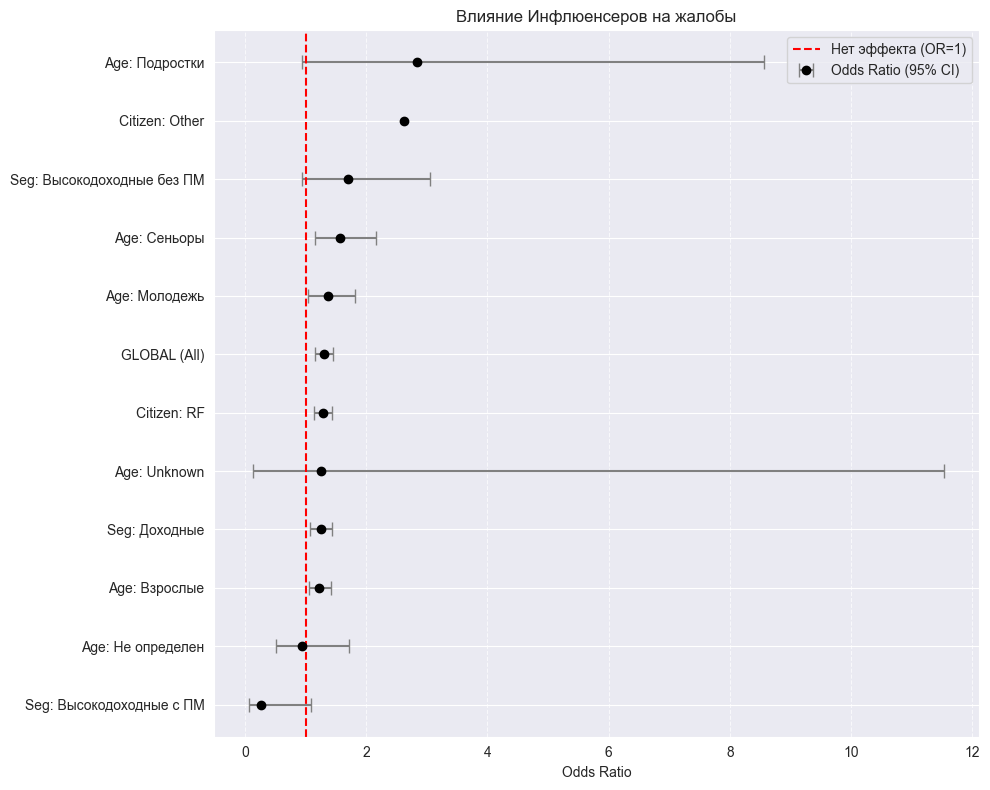

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
df = pd.read_csv('dfc.csv')
negative_reviews = df[df['review_emotion'] == 0].copy()
top_lines_99 = [
    'депозитные продукты', 'кредитные карты', 'инвестиции', 'прочие продукты',
    'автокредит', 'mobile', 'sme', 'нефинансовые продукты', 'премиальные сервисы', 'ипотека'
]
top_sources_99 = [
    'banki.ru', 'пульс', 'нет', 'otzovik', 'sravni.ru',
    'пикабу', 'вконтакте', 'суперапп', 'asn'
]
negative_reviews['age_segment'] = negative_reviews['age_segment'].fillna('Unknown')
negative_reviews['segment_name'] = negative_reviews['segment_name'].fillna('Unknown')
negative_reviews['citizenship_group'] = negative_reviews['citizenship_country'].apply(
    lambda x: 'RF' if x == 'РФ' else 'Other'
)
def get_segment_stats(subset_df, label):
    df_sub = subset_df.copy()
    df_sub['review_theme'] = df_sub['review_theme'].astype(str).str.strip()
    df_sub['target_is_tariff'] = df_sub['review_theme'].str.lower().str.contains('тарифы и условия').astype(int)

    df_sub['business_line_grouped'] = df_sub['business_line'].apply(lambda x: x if x in top_lines_99 else 'Other')
    df_sub['source_grouped'] = df_sub['review_source'].apply(lambda x: x if x in top_sources_99 else 'Other')

    df_sub['is_male'] = (df_sub['gender_cd'].fillna('Unknown') == 'M').astype(int)
    df_sub['influencer_flg'] = df_sub['influencer_flg'].fillna(0).astype(int)
    df_sub['new_flg'] = df_sub['new_flg'].fillna(0).astype(int)
    df_sub['solution_flg'] = df_sub['solution_flg'].fillna('Unknown')
    df_sub['is_mark_2'] = (df_sub['review_mark'].astype(str) == '2').astype(int)

    cat_features = ['business_line_grouped', 'source_grouped', 'solution_flg']
    num_features = ['is_male', 'influencer_flg', 'new_flg', 'is_mark_2']
    valid_num = [c for c in num_features if df_sub[c].nunique() > 1]

    model_df = df_sub[['target_is_tariff'] + cat_features + valid_num].copy()
    if model_df['target_is_tariff'].nunique() < 2: return None
    model_df = pd.get_dummies(model_df, columns=cat_features, drop_first=True)
    model_df = model_df.loc[:, (model_df != model_df.iloc[0]).any()]

    y = model_df['target_is_tariff']
    X = model_df.drop('target_is_tariff', axis=1)
    X = sm.add_constant(X)

    try:
        model = sm.Logit(y, X.astype(float)).fit(method='bfgs', maxiter=500, disp=0)
        y_prob = model.predict(X.astype(float))
        auc = roc_auc_score(y, y_prob)
        if 'influencer_flg' in model.params:
            coef = model.params['influencer_flg']
            or_val = np.exp(coef)
            ci = model.conf_int().loc['influencer_flg']
            or_low = np.exp(ci[0])
            or_high = np.exp(ci[1])
            pval = model.pvalues['influencer_flg']
        else:
            return None

        return {
            'Segment': label,
            'N': len(df_sub),
            'AUC': auc,
            'OR': or_val,
            'OR_low': or_low,
            'OR_high': or_high,
            'P-value': pval
        }
    except:
        return None

data = []
res = get_segment_stats(negative_reviews, "GLOBAL (All)")
if res: data.append(res)
for g in negative_reviews['age_segment'].unique():
    sub = negative_reviews[negative_reviews['age_segment'] == g]
    if len(sub) > 100:
        res = get_segment_stats(sub, f"Age: {g}")
        if res: data.append(res)

for g in negative_reviews['citizenship_group'].unique():
    sub = negative_reviews[negative_reviews['citizenship_group'] == g]
    if len(sub) > 100:
        res = get_segment_stats(sub, f"Citizen: {g}")
        if res: data.append(res)
for g in negative_reviews['segment_name'].unique():
    sub = negative_reviews[negative_reviews['segment_name'] == g]
    if len(sub) > 100:
        res = get_segment_stats(sub, f"Seg: {g}")
        if res: data.append(res)

results_df = pd.DataFrame(data)
plt.figure(figsize=(10, 8))
results_df = results_df.sort_values('OR', ascending=True)
errors = [results_df['OR'] - results_df['OR_low'], results_df['OR_high'] - results_df['OR']]
plt.errorbar(x=results_df['OR'], y=results_df['Segment'], xerr=errors,
             fmt='o', color='black', ecolor='gray', capsize=5, label='Odds Ratio (95% CI)')
plt.axvline(x=1, color='red', linestyle='--', label='Нет эффекта (OR=1)')
plt.title('Влияние Инфлюенсеров на жалобы')
plt.xlabel('Odds Ratio')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
print("Таблица результатов")
print(results_df[['Segment', 'N', 'AUC', 'OR', 'P-value']].to_markdown(index=False, floatfmt=".3f"))
plt.show()

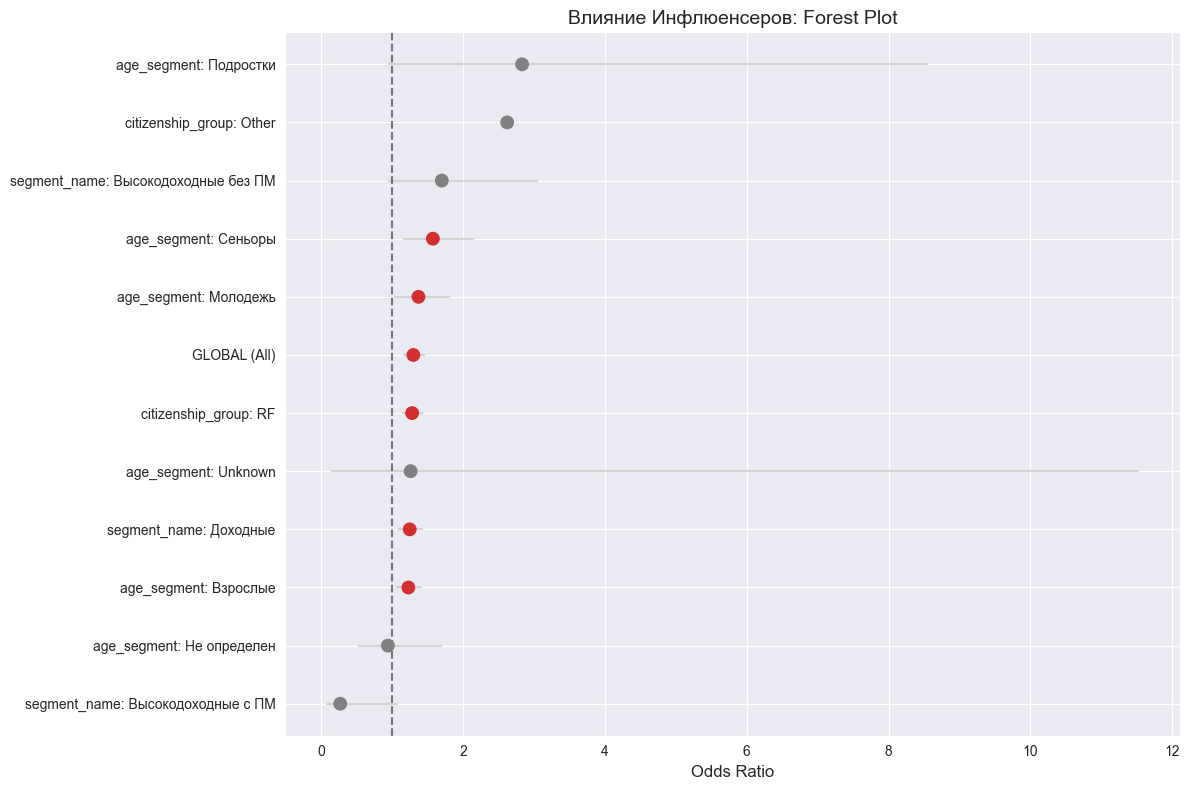

| Segment                             |     N |    AUC |     OR |   P-value | Significance   |
|:------------------------------------|------:|-------:|-------:|----------:|:---------------|
| segment_name: Высокодоходные с ПМ   |   448 | 0.8126 | 0.2693 |    0.0647 | *              |
| age_segment: Не определен           |   866 | 0.8111 | 0.9413 |    0.8423 |                |
| age_segment: Взрослые               | 10087 | 0.7770 | 1.2299 |    0.0066 | ***            |
| segment_name: Доходные              |  9569 | 0.8010 | 1.2489 |    0.0025 | ***            |
| age_segment: Unknown                |   262 | 0.8609 | 1.2617 |    0.8369 |                |
| citizenship_group: RF               | 18359 | 0.8005 | 1.2828 |    0.0000 | ***            |
| GLOBAL (All)                        | 18791 | 0.8051 | 1.2997 |    0.0000 | ***            |
| age_segment: Молодежь               |  4171 | 0.8559 | 1.3721 |    0.0288 | **             |
| age_segment: Сеньоры                |  2277 | 0.

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import warnings
from statsmodels.tools.sm_exceptions import HessianInversionWarning
warnings.simplefilter('ignore', HessianInversionWarning)
warnings.simplefilter('ignore', RuntimeWarning)
df = pd.read_csv('dfc.csv')
negative_reviews = df[df['review_emotion'] == 0].copy()
top_lines_99 = [
    'депозитные продукты', 'кредитные карты', 'инвестиции', 'прочие продукты',
    'автокредит', 'mobile', 'sme', 'нефинансовые продукты', 'премиальные сервисы', 'ипотека'
]
top_sources_99 = [
    'banki.ru', 'пульс', 'нет', 'otzovik', 'sravni.ru',
    'пикабу', 'вконтакте', 'суперапп', 'asn'
]
negative_reviews['age_segment'] = negative_reviews['age_segment'].fillna('Unknown')
negative_reviews['segment_name'] = negative_reviews['segment_name'].fillna('Unknown')
negative_reviews['citizenship_group'] = negative_reviews['citizenship_country'].apply(lambda x: 'RF' if x == 'РФ' else 'Other')
def get_segment_stats(subset_df, label):
    df_sub = subset_df.copy()
    df_sub['review_theme'] = df_sub['review_theme'].astype(str).str.strip()
    df_sub['target_is_tariff'] = df_sub['review_theme'].str.lower().str.contains('тарифы и условия').astype(int)

    df_sub['business_line_grouped'] = df_sub['business_line'].apply(lambda x: x if x in top_lines_99 else 'Other')
    df_sub['source_grouped'] = df_sub['review_source'].apply(lambda x: x if x in top_sources_99 else 'Other')

    df_sub['is_male'] = (df_sub['gender_cd'].fillna('Unknown') == 'M').astype(int)
    df_sub['influencer_flg'] = df_sub['influencer_flg'].fillna(0).astype(int)
    df_sub['new_flg'] = df_sub['new_flg'].fillna(0).astype(int)
    df_sub['solution_flg'] = df_sub['solution_flg'].fillna('Unknown')
    df_sub['is_mark_2'] = (df_sub['review_mark'].astype(str) == '2').astype(int)
    cat_features = ['business_line_grouped', 'source_grouped', 'solution_flg']
    num_features = ['is_male', 'influencer_flg', 'new_flg', 'is_mark_2']
    if df_sub['target_is_tariff'].nunique() < 2: return None
    if df_sub['influencer_flg'].nunique() < 2: return None
    valid_num = [c for c in num_features if df_sub[c].nunique() > 1]

    model_df = df_sub[['target_is_tariff'] + cat_features + valid_num].copy()
    model_df = pd.get_dummies(model_df, columns=cat_features, drop_first=True)
    model_df = model_df.loc[:, (model_df != model_df.iloc[0]).any()]

    y = model_df['target_is_tariff']
    X = model_df.drop('target_is_tariff', axis=1)
    X = sm.add_constant(X)

    try:
        model = sm.Logit(y, X.astype(float)).fit(method='bfgs', maxiter=1000, disp=0)

        y_prob = model.predict(X.astype(float))
        auc = roc_auc_score(y, y_prob)

        if 'influencer_flg' in model.params:
            coef = model.params['influencer_flg']
            or_val = np.exp(coef)
            try:
                pval = model.pvalues['influencer_flg']
                ci = model.conf_int().loc['influencer_flg']
                or_low = np.exp(ci[0])
                or_high = np.exp(ci[1])
            except:
                pval = np.nan
                or_low = or_val
                or_high = or_val
        else:
            return None

        return {
            'Segment': label,
            'N': len(df_sub),
            'AUC': auc,
            'OR': or_val,
            'OR_low': or_low,
            'OR_high': or_high,
            'P-value': pval
        }
    except Exception as e:
        return None


data = []
res = get_segment_stats(negative_reviews, "GLOBAL (All)")
if res: data.append(res)
for col in ['age_segment', 'citizenship_group', 'segment_name']:
    for g in negative_reviews[col].unique():
        sub = negative_reviews[negative_reviews[col] == g]
        if len(sub) > 100:
            res = get_segment_stats(sub, f"{col}: {g}")
            if res: data.append(res)

results_df = pd.DataFrame(data)
def get_sig(p):
    if pd.isna(p): return "N/A"
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.1: return "*"
    return ""

results_df['Significance'] = results_df['P-value'].apply(get_sig)
plt.figure(figsize=(12, 8))
results_df = results_df.sort_values('OR', ascending=True)

colors = []
for idx, row in results_df.iterrows():
    if pd.isna(row['P-value']):
        colors.append('gray')
    elif row['P-value'] < 0.05:
        colors.append('#D32F2F' if row['OR'] > 1 else '#388E3C')
    else:
        colors.append('gray')

errors = [results_df['OR'] - results_df['OR_low'], results_df['OR_high'] - results_df['OR']]

plt.errorbar(x=results_df['OR'], y=results_df['Segment'], xerr=errors,
             fmt='none', ecolor='lightgray', capsize=0)
plt.scatter(x=results_df['OR'], y=results_df['Segment'], c=colors, s=80, zorder=3)
plt.axvline(x=1, color='black', linestyle='--', alpha=0.5)
plt.title('Влияние Инфлюенсеров: Forest Plot', fontsize=14)
plt.xlabel('Odds Ratio', fontsize=12)
plt.tight_layout()
plt.show()
print(results_df[['Segment', 'N', 'AUC', 'OR', 'P-value', 'Significance']].to_markdown(floatfmt=".4f", index=False))